<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/kalman/experimentation/Kalman_Filters_for_Nifty_ema.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [126]:
!pip install pykalman
!pip install yfinance
!pip install pandas-ta==0.2.45b
!pip install ffn

In [127]:
#Importing dependencies#
from pykalman import KalmanFilter
import numpy as np
import pylab as pl
import pandas as pd
import yfinance as yf
from scipy import poly1d
from datetime import datetime
import pandas_ta as ta
import matplotlib.pyplot as plt
import ffn
%matplotlib inline
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'ignore', 'invalid': 'ignore', 'over': 'warn', 'under': 'ignore'}

[*********************100%***********************]  1 of 1 completed


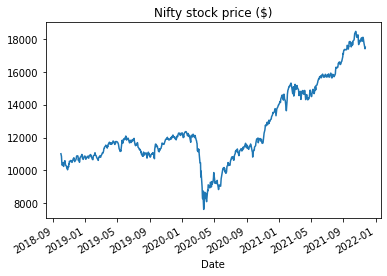

In [155]:
nifty_df = yf.download('^nsei',start='2018-10-01') # 2018
nifty_df['Adj Close'].plot(title='Nifty stock price ($)');


In [156]:
#nifty_df = yf.download('sbin.ns',start='2014-01-01',progress=False)


In [157]:
df = nifty_df[['Adj Close']]


mean 17540.100003664174


Text(0.5, 0, 'Days')

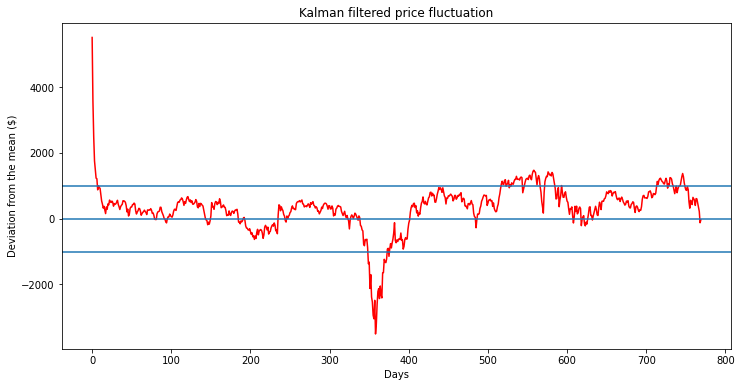

In [158]:
f = KalmanFilter(transition_matrices = [1],
                  observation_matrices = [1],
                  initial_state_mean = 0,
                  initial_state_covariance = 0.1,
                  observation_covariance = 0.1,
                  transition_covariance = 0.0001)#.0001
mean, cov = f.filter(df['Adj Close'].values)
mean, std = mean.squeeze(), np.std(cov.squeeze())
print(f'mean {mean[-1]}')

plt.figure(figsize=(12,6))
plt.plot(df['Adj Close'].values - mean, 'red', lw=1.5)

plt.axhline(y=0)
plt.axhline(y=1000)
plt.axhline(y=-1000)
plt.title("Kalman filtered price fluctuation")
plt.ylabel("Deviation from the mean ($)")
plt.xlabel("Days")

In [159]:
nifty =pd.DataFrame({'Date': nifty_df.index,'Close':df['Adj Close'].values - mean})


In [160]:
nifty['30 Day MA'] = nifty['Close'].rolling(window=20).mean()
# set .std(ddof=0) for population std instead of sample
nifty['30 Day STD'] = nifty['Close'].rolling(window=20).std() 
nifty['Upper Band'] = nifty['30 Day MA'] + (nifty['30 Day STD'] *0.5)
nifty['Lower Band'] = nifty['30 Day MA'] - (nifty['30 Day STD'] *0.5)

nifty.ta.macd(fast=48,slow=100,signal=24, append=True)

print()

In [161]:
nifty=nifty.set_index('date')

In [162]:
nifty.tail(2)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_48_100_24,MACDh_48_100_24,MACDs_48_100_24
date,,,,,,,,
2021-11-22,-124.729892,560.578924,269.264305,695.211076,425.946771,-20.003268,-80.395503,60.392235
2021-11-23,-36.750394,510.442573,282.818894,651.852020,369.033126,-35.289009,-88.026744,52.737735


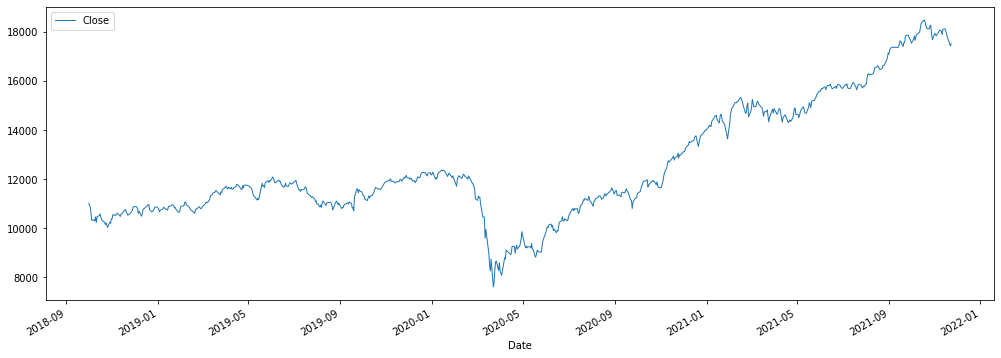

In [163]:
nifty_df[['Close']][-1000:].plot(figsize=(17,6),linewidth=1);

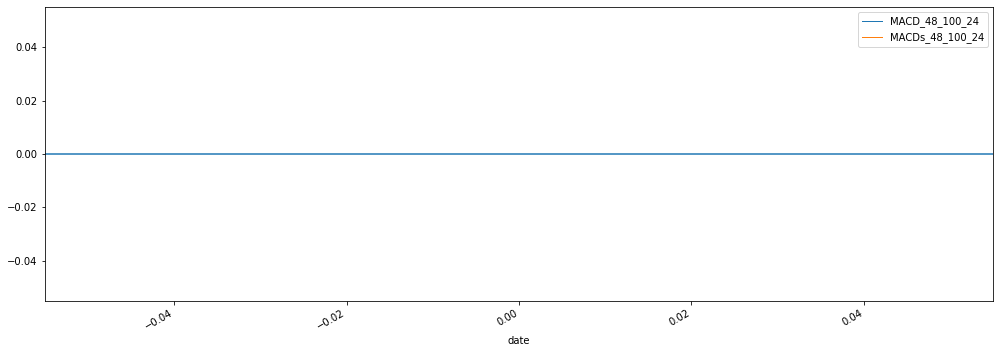

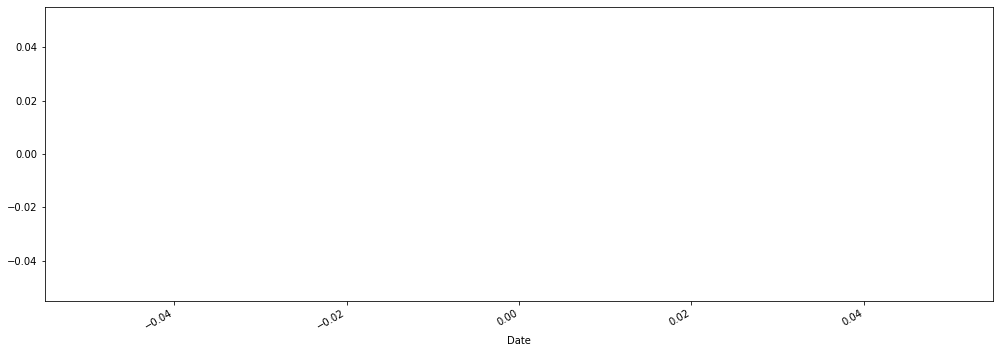

In [164]:
nifty[['MACD_48_100_24','MACDs_48_100_24']][-2000:-1000].plot(figsize=(17,6),linewidth=1);
plt.axhline(y=0);
plt.show()
nifty_df['Close'][-2000:-1000].plot(figsize=(17,6),linewidth=1);


In [165]:
nifty['slope']=abs(nifty['MACD_48_100_24'].diff(5))
nifty['slope']=np.where(nifty['slope']<=10,0,nifty['slope'])
nifty['slope_s']=abs(nifty['MACDs_48_100_24'].diff(5))
nifty['slope_s']=np.where(nifty['slope_s']<=10,0,nifty['slope_s'])

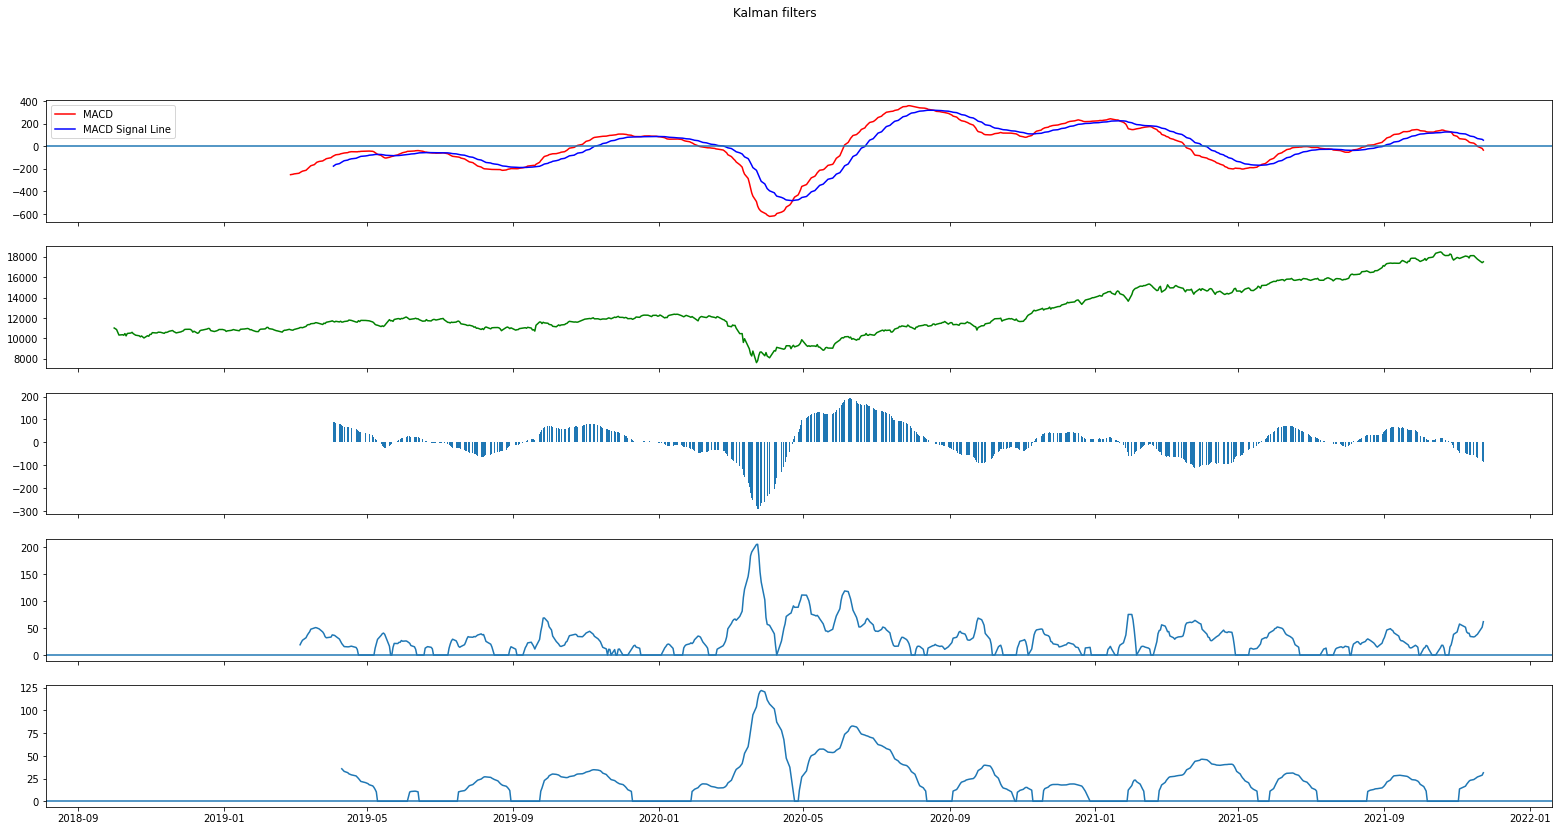

In [166]:
fig, ax = plt.subplots(5,1,figsize=(27,13),linewidth=1,sharex=True)
ax[0].plot(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACD_48_100_24'][-1000:],'r', label='MACD')
ax[0].plot(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACDs_48_100_24'][-1000:],'b', label='MACD Signal Line')
ax[2].bar(nifty.loc[:, :].index[-1000:], nifty.loc[:, 'MACDh_48_100_24'][-1000:], label='MACD Signal Line')
ax[1].plot(nifty_df.loc[:, :].index[-1000:], nifty_df.loc[:, 'Close'][-1000:],'g', label='NH moving avg 50 days')
ax[3].plot(nifty.iloc[:, :].index[-1000:], nifty.loc[:, 'slope'][-1000:], label='Slope')
ax[4].plot(nifty.iloc[:, :].index[-1000:], nifty.loc[:, 'slope_s'][-1000:], label='Slope')
plt.suptitle('Kalman filters')
ax[0].axhline(y=0)
ax[3].axhline(y=0)
ax[4].axhline(y=0)
ax[0].legend(loc='upper left')
plt.show()


In [167]:
nifty.tail(1)

,close,30 Day MA,30 Day STD,Upper Band,Lower Band,MACD_48_100_24,MACDh_48_100_24,MACDs_48_100_24,slope,slope_s
date,,,,,,,,,,
2021-11-23,-36.750394,510.442573,282.818894,651.85202,369.033126,-35.289009,-88.026744,52.737735,61.898787,31.363732


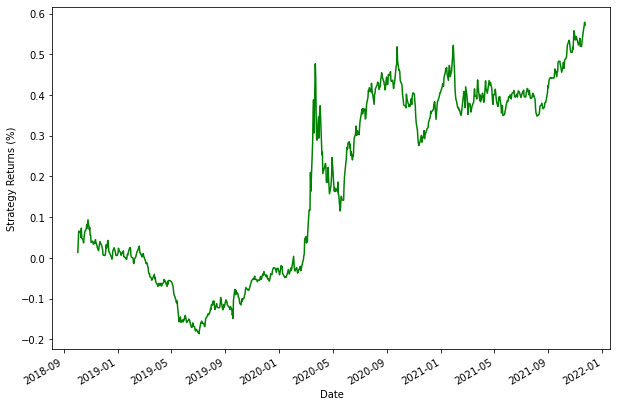

sharpe ratio :  0.05113581525223962
sortino ratio :  0.22927912632720088


In [170]:
nifty['signals']=np.where(nifty['MACDh_48_100_24']>0,1,-1)
# Calculate daily returns
nifty['Return'] = nifty_df.Close.pct_change()
 
# Calculate strategy returns
nifty['Strategy_F'] = nifty.Return * nifty.signals.shift(1)

# Calculate geometric returns
geometric_returns = ((nifty.Strategy_F+1).cumprod()-1)
#np.sum(np.log(data/data.shift())*portfolio, axis=1)
# Plot geometric returns
geometric_returns.plot(figsize=(10, 7),color='g')
volatility = geometric_returns.std() * np.sqrt(252)
sharpe_ratio = (geometric_returns.mean() - 0.05/252) / volatility 
plt.ylabel("Strategy Returns (%)")
plt.xlabel("Date")
plt.show()
print('sharpe ratio : ' ,sharpe_ratio)
std_neg = geometric_returns[geometric_returns<0].std()*np.sqrt(252)
sortino_ratio=(geometric_returns.mean() - 0.05/252)/std_neg
print('sortino ratio : ' , sortino_ratio) 

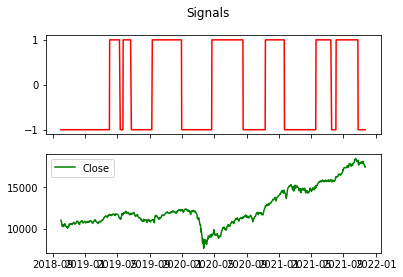

In [171]:
fig, ax = plt.subplots(2,1,sharex=True)
ax[0].plot(nifty.loc[:, :].index, nifty.loc[:, 'signals'],'r', label='Signals')
ax[1].plot(df.loc[:, :].index, df.loc[:, 'Adj Close'],'g', label='Close')
#ax[1].plot(nifty.iloc[:, :].index, nifty.loc[:, 'Close'], label='Nifty')
plt.suptitle('Signals')
ax[1].legend()
plt.show()


In [172]:
stats = geometric_returns.calc_stats()  # use .calc_stats() on a series to invoke ffn.
stats.display()

Stats for Strategy_F from 2018-10-01 00:00:00 - 2021-11-23 00:00:00
Annual risk-free rate considered: 0.00%
Summary:
Total Return      Sharpe  CAGR     Max Drawdown
--------------  --------  -------  --------------
-                   0.54  228.48%  -298.58%

Annualized Returns:
mtd    3m      6m      ytd     1y      3y       5y    10y    incep.
-----  ------  ------  ------  ------  -------  ----  -----  --------
2.35%  54.31%  63.42%  40.68%  90.49%  166.81%  -     -      228.48%

Periodic:
        daily      monthly    yearly
------  ---------  ---------  ---------
sharpe  0.54       -0.25      -0.93
mean    7327.91%   -135.32%   -648.87%
vol     13545.74%  542.29%    699.96%
skew    27.46      -0.96      -0.13
kurt    758.93     11.00      -
best    23575.89%  533.96%    40.68%
worst   -1141.25%  -637.51%   -1358.80%

Drawdowns:
max       avg        # days
--------  -------  --------
-298.58%  -42.91%      79.5

Misc:
---------------  -------
avg. up month    54.58%
avg. down month

In [173]:
stats.stats

start                    2018-10-01 00:00:00
end                      2021-11-23 00:00:00
rf                                         0
total_return                             NaN
cagr                                 2.28476
max_drawdown                        -2.98583
calmar                              0.765202
mtd                                0.0235445
three_month                         0.543103
six_month                           0.634155
ytd                                  0.40681
one_year                            0.904936
three_year                           1.66809
five_year                                NaN
ten_year                                 NaN
incep                                2.28476
daily_sharpe                        0.540976
daily_sortino                        8.58608
daily_mean                           73.2791
daily_vol                            135.457
daily_skew                           27.4645
daily_kurt                           758.934
best_day  

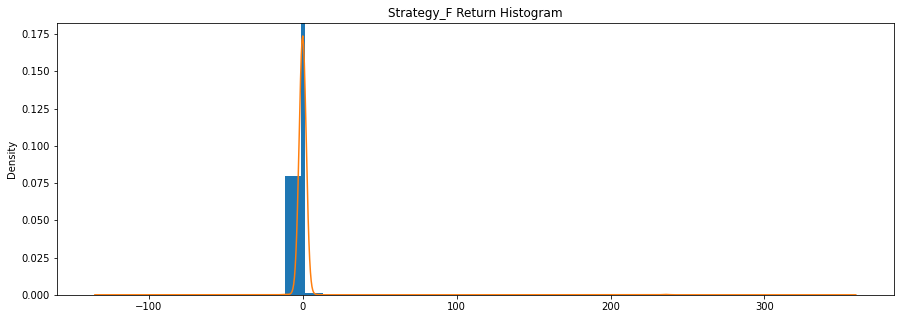

In [174]:
stats.plot_histogram()

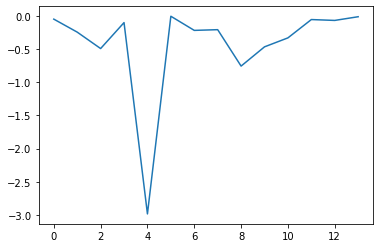

In [175]:
stats.drawdown_details['drawdown'].plot();

In [176]:
stats.display_monthly_returns()

  Year     Jan      Feb      Mar     Apr     May    Jun     Jul    Aug     Sep     Oct     Nov     Dec       YTD
------  ------  -------  -------  ------  ------  -----  ------  -----  ------  ------  ------  ------  --------
  2018    0        0        0       0       0      0       0      0       0     305.15  -88.09   -7.24    -55.25
  2019   30.97    35.21  -637.51   -3.92  174     14.55  -27.77  -4.43  -27.65  -36.66  -25.65  -21.71   -628.49
  2020  -47.86  -376.01   533.96  -16.14  -14.34  43.2    32.24  10.97    3.06  -11.39  -25.03   33.5   -1358.8
  2021   28.65   -19.52    -4.77    0.32   -3.94   3.2     0.36   5.86    9.55   20.43    2.35    0        40.68
